<a href="https://colab.research.google.com/github/JhulianaM/Mammography/blob/master/tranEdsrRuido1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Sube el archivo kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip -d mias

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 99% 309M/312M [00:14<00:00, 25.5MB/s]
100% 312M/312M [00:14<00:00, 21.9MB/s]
Archive:  mias-mammography.zip
  inflating: mias/Info.txt           
  inflating: mias/all-mias.tar.gz    
  inflating: mias/all-mias/Info.txt  
  inflating: mias/all-mias/Licence.txt  
  inflating: mias/all-mias/README    
  inflating: mias/all-mias/mdb001.pgm  
  inflating: mias/all-mias/mdb002.pgm  
  inflating: mias/all-mias/mdb003.pgm  
  inflating: mias/all-mias/mdb004.pgm  
  inflating: mias/all-mias/mdb005.pgm  
  inflating: mias/all-mias/mdb006.pgm  
  inflating: mias/all-mias/mdb007.pgm  
  inflating: mias/all-mias/mdb008.pgm  
  inflating: mias/all-mias/mdb009.pgm  
  inflating: mias/all-mias/mdb010.pgm  
  inflating: mias/all-mias/mdb011.pgm  
  inflating: mias/all-mias/mdb012.pgm  
  inflating: mias/all-mias/mdb013.pgm  
  inflating: mias/all-mias/mdb014.pgm  
  inflating: mias

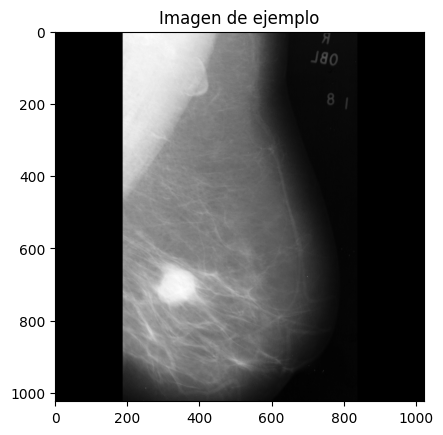

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Directorio de imágenes
data_dir = "mias/all-mias/"

# Cargar imágenes
# Crear una lista con las img en escala de grises
images = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.pgm'):
        img_path = os.path.join(data_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)

# Visualizar una imagen de ejemplo
plt.imshow(images[0], cmap='gray')
plt.title("Imagen de ejemplo")
plt.show()

# Normalización y preparación
images = np.array(images) #convertimos en arreglo
images = images.astype('float32') / 255.0

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Descargar y cargar el modelo EDSR preentrenado
!git clone https://github.com/Saafke/EDSR_Tensorflow.git
%cd EDSR_Tensorflow

Cloning into 'EDSR_Tensorflow'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 149 (delta 1), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (149/149), 162.50 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/EDSR_Tensorflow


In [4]:
def load_pb_model(model_path):
    with tf.io.gfile.GFile(model_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    session = tf.compat.v1.Session(graph=tf.Graph())
    with session.graph.as_default():
        tf.import_graph_def(graph_def, name="")
    return session

In [5]:
# Cargar el modelo EDSR x4
model_path = '/content/EDSR_Tensorflow/models/EDSR_x4.pb'
session = load_pb_model(model_path)

# Obtener el grafo y las operaciones de entrada y salida
graph = session.graph
input_tensor = graph.get_tensor_by_name("IteratorGetNext:0")
output_tensor = graph.get_tensor_by_name("NCHW_output:0")

In [12]:
# Convertir imágenes en escala de grises a imágenes RGB
val_images = images[:10]
val_images_rgb = [np.stack((img,)*3, axis=-1) for img in val_images]

# Realizar la bajada de resolución
val_images_resized = [cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)) for img in val_images_rgb]

noise_std = 0.03
val_images_noisy = [img + noise_std * np.random.randn(*img.shape) for img in val_images_resized]
val_images_noisy = np.clip(val_images_noisy, 0, 1)
# Agregar ruido gaussiano a las imágenes de baja resolución
#val_images_noisy = [add_gaussian_noise(img) for img in val_images_resized]
# Convertir imágenes a uint8 para OpenCV
val_images_resized_uint8 = [np.uint8(img * 255) for img in val_images_resized]
val_images_noisy_uint8 = [np.uint8(img * 255) for img in val_images_noisy]

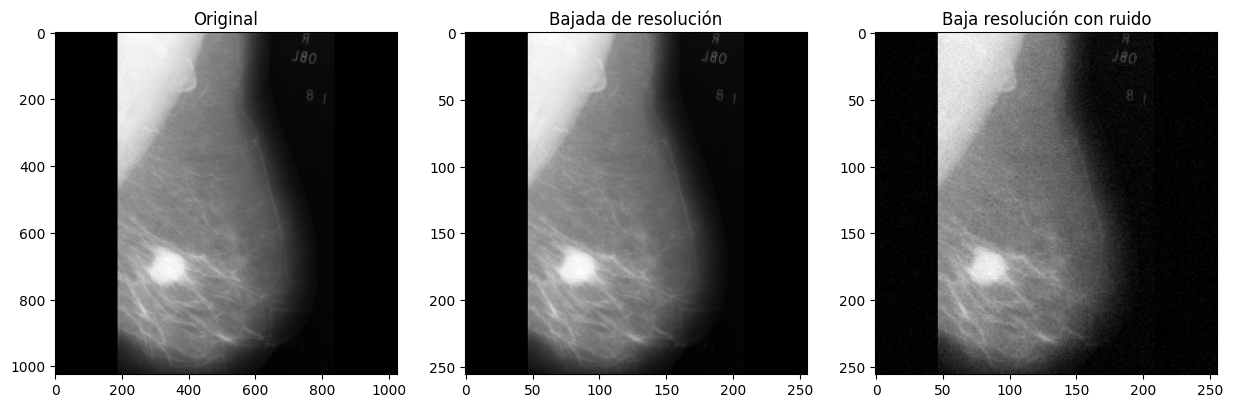

In [13]:
# Mostrar una imagen original, su versión de baja resolución y su versión con ruido
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(val_images[0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Bajada de resolución')
plt.imshow(cv2.cvtColor(val_images_resized_uint8[0], cv2.COLOR_BGR2GRAY), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Baja resolución con ruido')
plt.imshow(cv2.cvtColor(val_images_noisy_uint8[0], cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

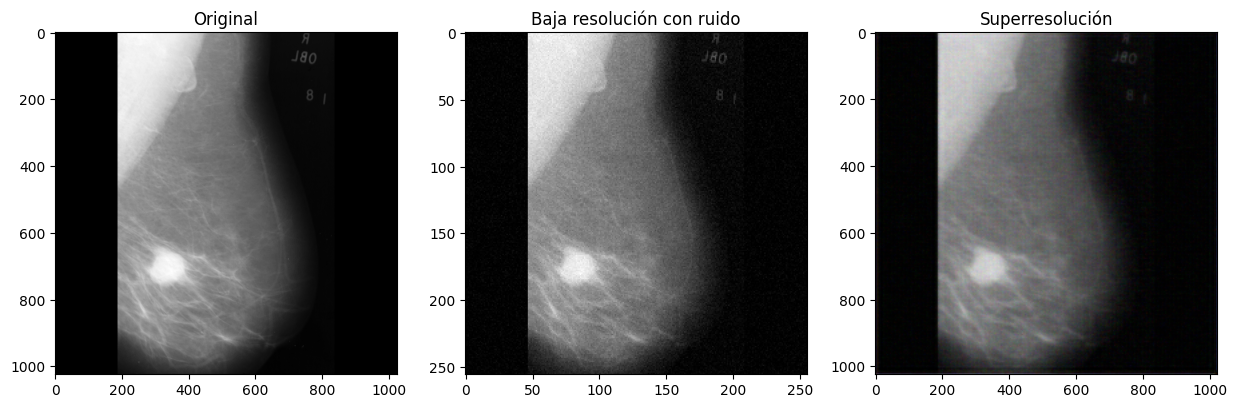

<ipython-input-15-36e61240c5ba>:37: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = compare_psnr(original_img, superres_img_gray)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Imagen 1 - PSNR: 9.85, SSIM: 0.3853


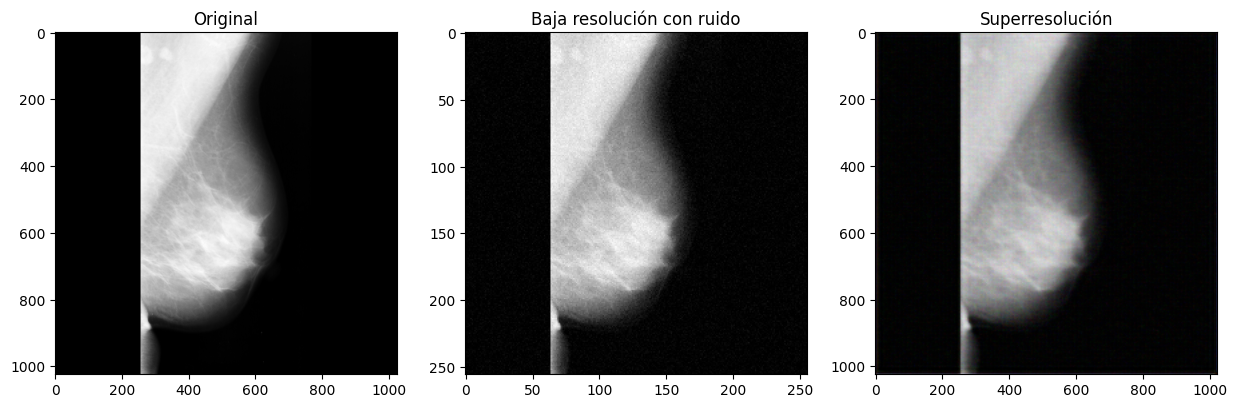

Imagen 2 - PSNR: 9.14, SSIM: 0.6308


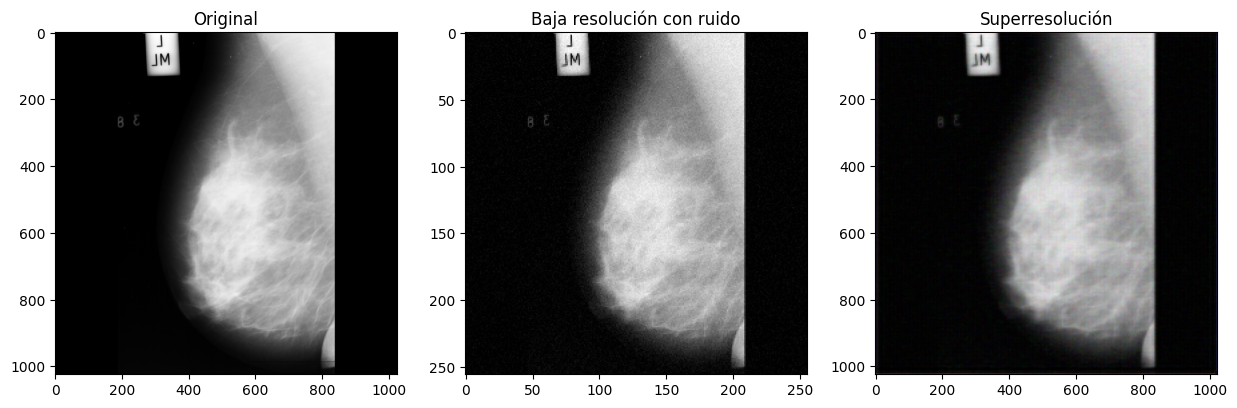

Imagen 3 - PSNR: 7.95, SSIM: 0.4991


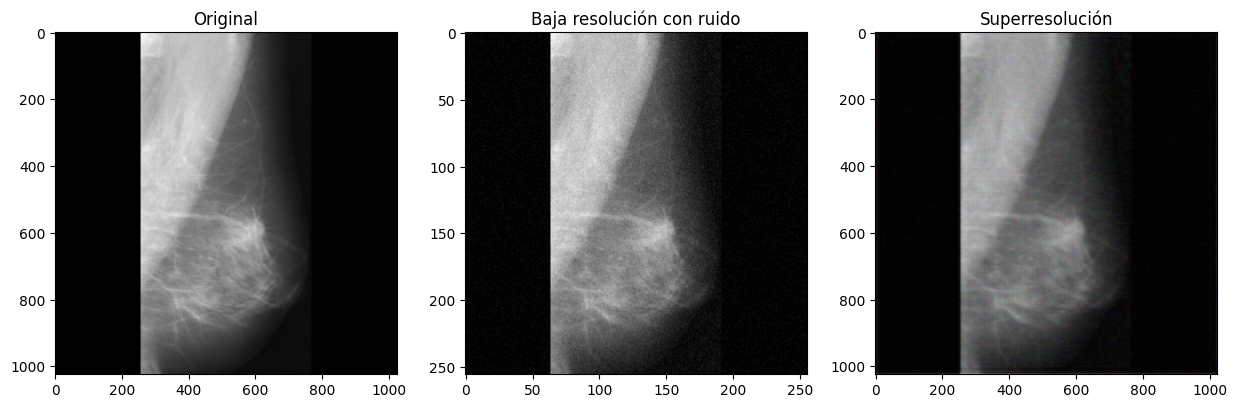

Imagen 4 - PSNR: 10.45, SSIM: 0.4997


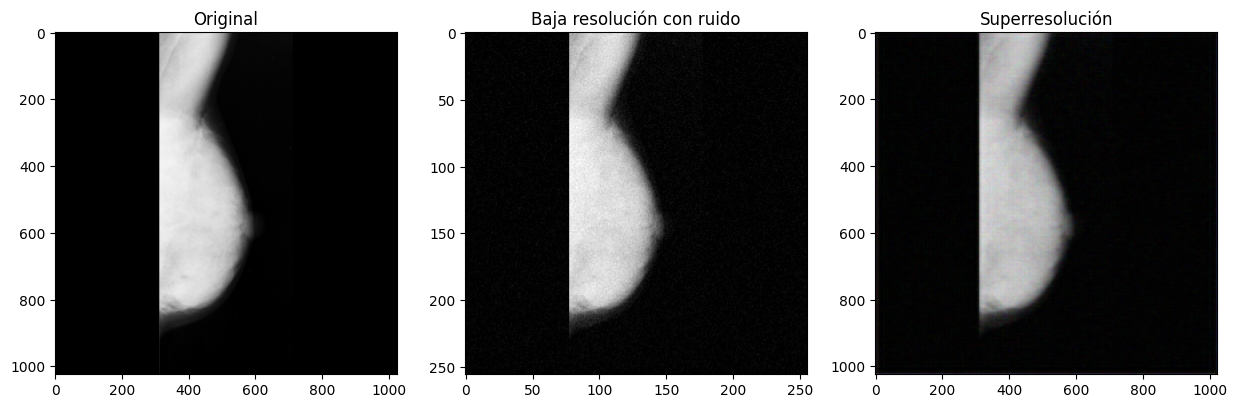

Imagen 5 - PSNR: 10.91, SSIM: 0.7380
PSNR promedio: 9.66, SSIM promedio: 0.5506


In [15]:
# Convertir las imágenes a formato de tensor
val_images_noisy = np.array(val_images_noisy)

# Realizar la inferencia
predicted_images = []
for img in val_images_noisy:
    img = np.expand_dims(img, axis=0)
    output_img = session.run(output_tensor, feed_dict={input_tensor: img})
    predicted_images.append(output_img[0])

# Visualizar las imágenes originales, de baja resolución con ruido y superresolucionadas
psnr_values = []
ssim_values = []

for i in range(5):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(val_images[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Baja resolución con ruido')
    plt.imshow(cv2.cvtColor(val_images_noisy_uint8[i], cv2.COLOR_BGR2GRAY), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Superresolución')
    superres_img = np.transpose(predicted_images[i], (1, 2, 0))
    plt.imshow(superres_img, cmap='gray')
    plt.show()

    # Calcular PSNR y SSIM
    original_img = (val_images[i] * 255).astype(np.uint8)
    noisy_img_gray = cv2.cvtColor(val_images_noisy_uint8[i], cv2.COLOR_BGR2GRAY)
    superres_img_gray = cv2.cvtColor(superres_img, cv2.COLOR_BGR2GRAY)

    psnr_value = compare_psnr(original_img, superres_img_gray)
    ssim_value = compare_ssim(original_img, superres_img_gray)

    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

    print(f'Imagen {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')

# Mostrar los valores promedio de PSNR y SSIM
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
print(f'PSNR promedio: {average_psnr:.2f}, SSIM promedio: {average_ssim:.4f}')


ahora con x2 ruido 0.03

In [16]:
# Cargar el modelo EDSR x2
model_path2 = 'models/EDSR_x2.pb'
session = load_pb_model(model_path2)

In [18]:
# Realizar la bajada de resolución
val_images_resized2 = [cv2.resize(img, (img.shape[1]//2, img.shape[0]//2)) for img in val_images_rgb2]


In [23]:
# Añadir ruido gaussiano a las imágenes de baja resolución
noise_std = 0.03
val_images_noisy2 = [img + noise_std * np.random.randn(*img.shape) for img in val_images_resized2]
val_images_noisy2 = np.clip(val_images_noisy2, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]

# Convertir imágenes a uint8 para OpenCV
val_images_resized2_uint8 = [np.uint8(img * 255) for img in val_images_resized2]
val_images_noisy2_uint8 = [np.uint8(img * 255) for img in val_images_noisy2]


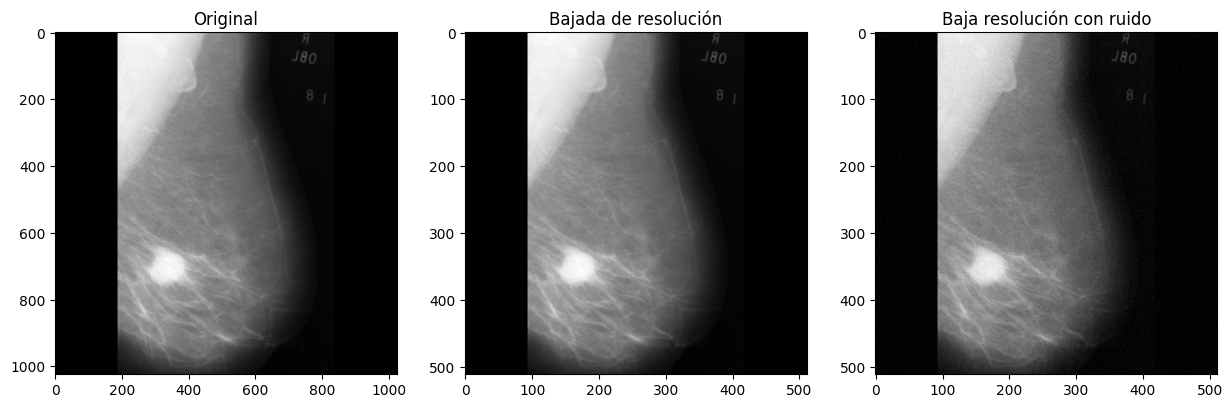

In [24]:
# Mostrar una imagen original, su versión de baja resolución y su versión con ruido
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(val_images[0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Bajada de resolución')
plt.imshow(cv2.cvtColor(val_images_resized_uint8[0], cv2.COLOR_BGR2GRAY), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Baja resolución con ruido')
plt.imshow(cv2.cvtColor(val_images_noisy_uint8[0], cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

In [22]:
# Convertir las imágenes a formato de tensor
val_images_noisy2 = np.array(val_images_noisy2)

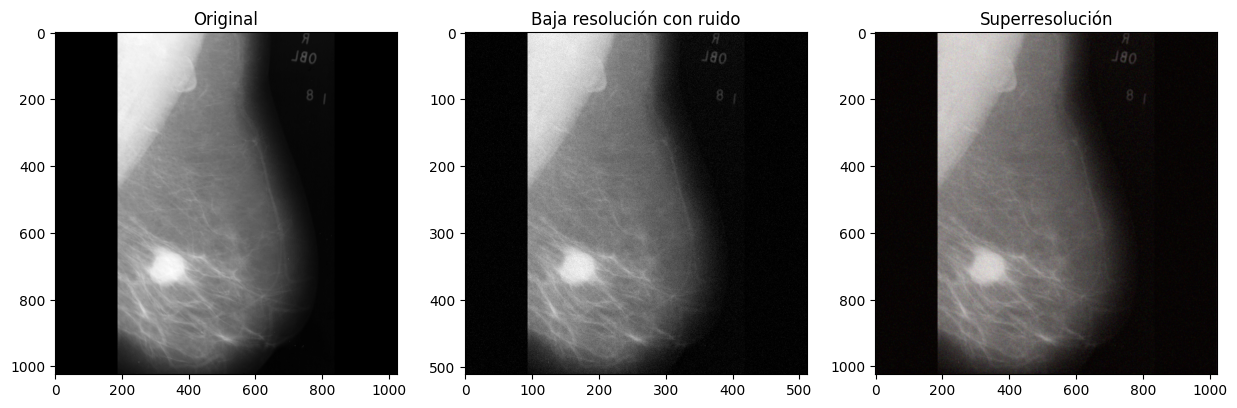

<ipython-input-25-e82c1a3110c4>:34: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = compare_psnr(original_img, superres_img_gray2)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Imagen 1 - PSNR: 10.91, SSIM: 0.7429


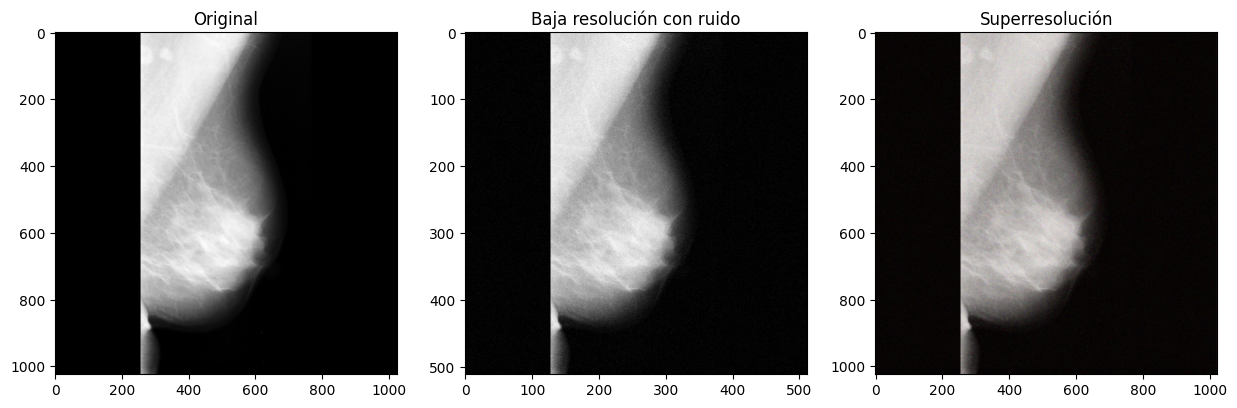

Imagen 2 - PSNR: 10.91, SSIM: 0.7415


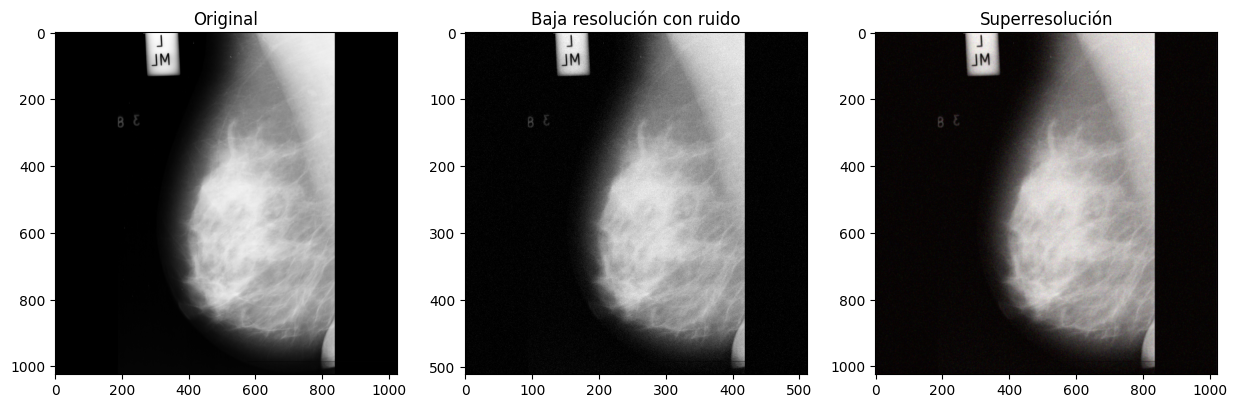

Imagen 3 - PSNR: 10.90, SSIM: 0.7532


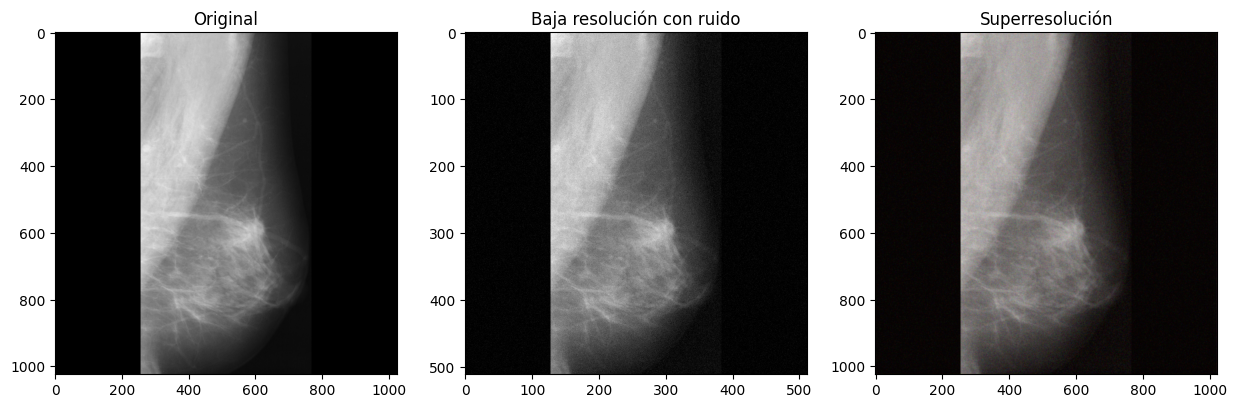

Imagen 4 - PSNR: 10.91, SSIM: 0.7477


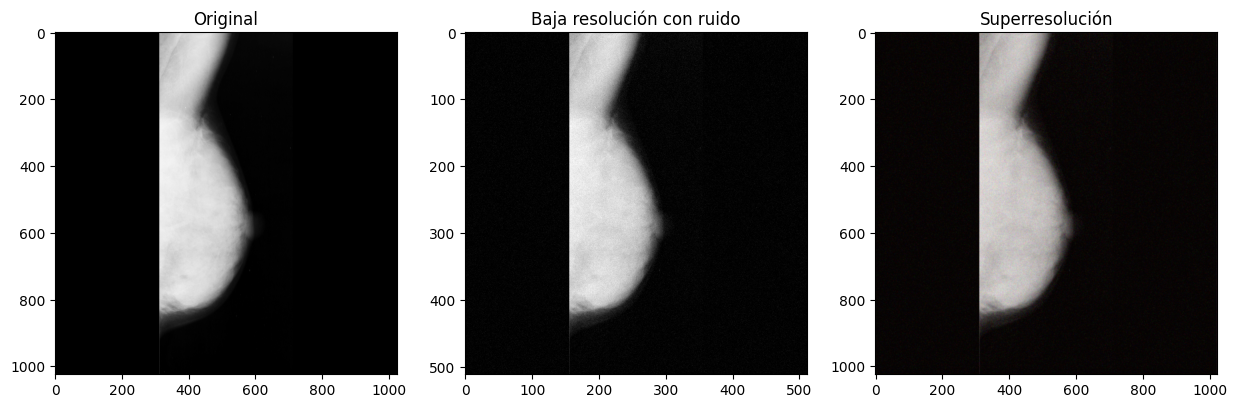

Imagen 5 - PSNR: 10.92, SSIM: 0.7385
PSNR promedio: 10.91, SSIM promedio: 0.7447


In [25]:
# Realizar la inferencia
predicted_images2 = []
for img in val_images_noisy2:
    img = np.expand_dims(img, axis=0)
    output_img = session.run(output_tensor, feed_dict={input_tensor: img})
    predicted_images2.append(output_img[0])

# Visualizar las imágenes originales, de baja resolución con ruido y superresolucionadas
psnr_values = []
ssim_values = []

for i in range(5):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(val_images2[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Baja resolución con ruido')
    plt.imshow(cv2.cvtColor(val_images_noisy2_uint8[i], cv2.COLOR_BGR2GRAY), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Superresolución')
    superres_img2 = np.transpose(predicted_images2[i], (1, 2, 0))
    plt.imshow(superres_img2, cmap='gray')
    plt.show()

    # Calcular PSNR y SSIM
    original_img2 = (val_images2[i] * 255).astype(np.uint8)
    noisy_img_gray2 = cv2.cvtColor(val_images_noisy2_uint8[i], cv2.COLOR_BGR2GRAY)
    superres_img_gray2 = cv2.cvtColor(superres_img2, cv2.COLOR_BGR2GRAY)

    psnr_value = compare_psnr(original_img, superres_img_gray2)
    ssim_value = compare_ssim(original_img, superres_img_gray2)

    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

    print(f'Imagen {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')

# Mostrar los valores promedio de PSNR y SSIM
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
print(f'PSNR promedio: {average_psnr:.2f}, SSIM promedio: {average_ssim:.4f}')